# lab3: This is the title of the assignment

In [228]:
%pip install -r requirements.txt
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement imblearn.over_sampling (from versions: none)
ERROR: No matching distribution found for imblearn.over_sampling


Note: you may need to restart the kernel to use updated packages.


## Imports

Authors:  
AlaaAbdulrazzaq Abdulrazzaq  
Name Author 2  
(use double space to break lines on markdowns)

In [229]:
import numpy as np
import pandas as pd 
import matplotlib as mp
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

This section should load the raw dataset for the task.  
Remember to use relative paths to load any files in the notebook.

In [230]:
# Always use comments in the code to document specific steps
diabetes_Data = pd.read_csv('raw_data/diabetic_data.csv')
diabetes_Data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [231]:
admission_Data = pd.read_csv('raw_data/IDS_mapping.csv')
admission_Data.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


## Task 1: Cleanup the data

This section handles the cleanup of the dataset and splitting of the data

both data.csv and IDS mapping files are loaded, the different sections of the IDS mappings are sorted and taken into account when reading the file. 
Description of admission are merged into the dataset file 

In [232]:
# Load the dataset
file_path = "raw_data/diabetic_data.csv"
df = pd.read_csv(file_path, dtype=str)

# Replace '?' and other non-standard missing values with NaN
df.replace(['?', 'Unknown/Invalid', 'Not Available', 'NULL'], np.nan, inplace=True)

# Convert age ranges to numeric values (mean of range)
age_map = {
    "[0-10)": 5, "[10-20)": 15, "[20-30)": 25, "[30-40)": 35,
    "[40-50)": 45, "[50-60)": 55, "[60-70)": 65, "[70-80)": 75,
    "[80-90)": 85, "[90-100)": 95
}
df["age"] = df["age"].map(age_map)

# Convert numeric columns properly
numeric_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency", "number_inpatient",
    "number_diagnoses"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df.groupby("age")[col].transform(lambda x: x.fillna(x.mean()))  # Fill missing values by age group mean

# Handle missing values for categorical columns
df.fillna(df.mode().iloc[0], inplace=True)

# Drop rows with NaN in critical columns
df.dropna(subset=["age", "time_in_hospital", "num_medications", "number_diagnoses"], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Display cleaned dataset summary
df.to_csv("cleaned_diabetic_data.csv", index=False)
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,5,[75-100),6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,15,[75-100),1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,25,[75-100),1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,35,[75-100),1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,45,[75-100),1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data Preprocessing

In [233]:
import pandas as pd

# Drop rows where 'readmitted' is 'NO'
df = df[df["readmitted"] != "NO"]

# Convert 'readmitted' to binary (1 for <30, 0 for >30)
target_mapping = {'>30': 0, '<30': 1}
df["readmitted"] = df["readmitted"].map(target_mapping)

# Define columns to remove
columns_to_remove = ["readmitted", "encounter_id", "patient_nbr", "weight", "payer_code", "medical_specialty"]

# Keep only columns that exist in df
columns_to_remove = [col for col in columns_to_remove if col in df.columns]

# Drop columns and define X (features) and y (target)
X = df.drop(columns=columns_to_remove)
y = df["readmitted"]

# Print dataset information
print(f"Dataset shape after dropping 'NO' readmissions: {df.shape}")
print("Class distribution in target variable:")
print(y.value_counts())


Dataset shape after dropping 'NO' readmissions: (46902, 50)
Class distribution in target variable:
readmitted
0    35545
1    11357
Name: count, dtype: int64


Data Splitting

In [234]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Encode categorical features before applying SMOTE
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Convert categories to numbers

# Now split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert everything to numeric (should work now)
X_train = X_train.apply(pd.to_numeric)  
X_test = X_test.apply(pd.to_numeric)  


Handling Imbalanced Data with SMOTE

In [235]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training data
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Print new class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
readmitted
0    28436
1     9085
Name: count, dtype: int64


Feature Scaling

In [236]:
from sklearn.preprocessing import StandardScaler

# Scale features for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Keep X_test scaling consistent



Imputation

In [237]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode categorical features before imputation
categorical_cols = X.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Split dataset: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Mean Imputation
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


Model Training

Training Random Forest (Optimized)...

--- Random Forest (Optimized) Performance ---

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      7109
           1       0.36      0.22      0.27      2272

    accuracy                           0.71      9381
   macro avg       0.57      0.55      0.55      9381
weighted avg       0.68      0.71      0.69      9381



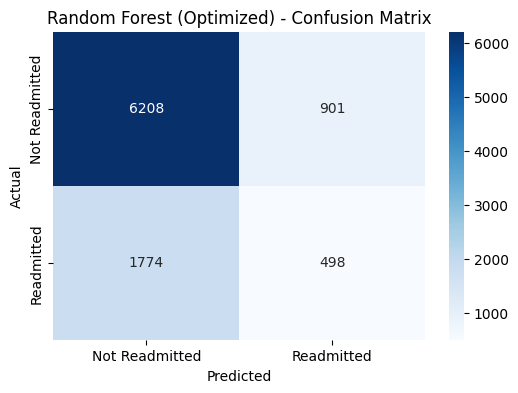

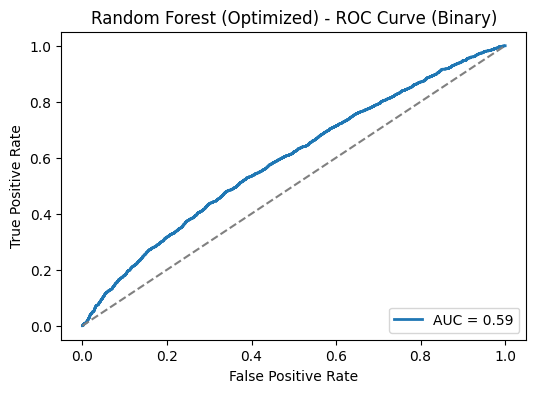

AUC Score: 0.59
Training Gradient Boosting (Optimized)...

--- Gradient Boosting (Optimized) Performance ---

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      7109
           1       0.46      0.10      0.16      2272

    accuracy                           0.75      9381
   macro avg       0.61      0.53      0.51      9381
weighted avg       0.69      0.75      0.69      9381



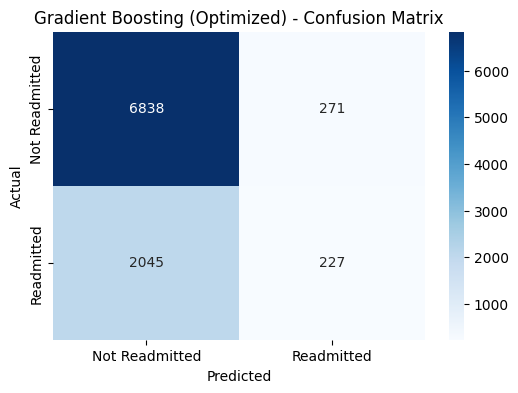

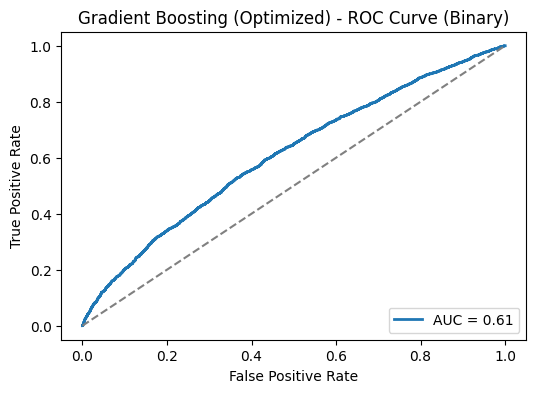

AUC Score: 0.61
Training Logistic Regression...

--- Logistic Regression Performance ---

              precision    recall  f1-score   support

           0       0.78      0.62      0.69      7109
           1       0.28      0.46      0.35      2272

    accuracy                           0.58      9381
   macro avg       0.53      0.54      0.52      9381
weighted avg       0.66      0.58      0.61      9381



c:\Users\Alan\anaconda3\envs\lab3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


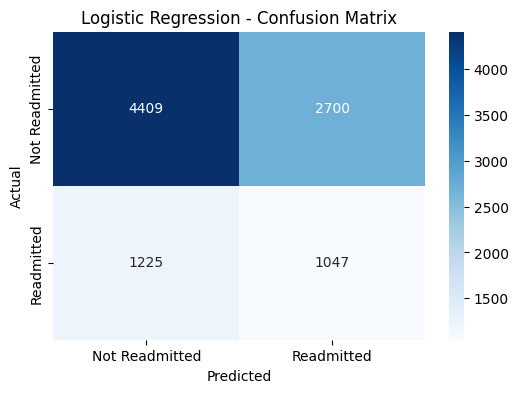

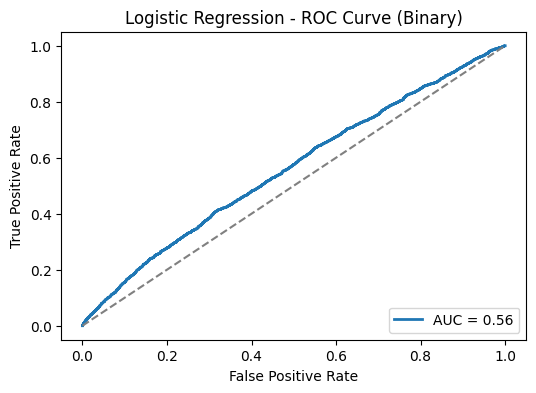

AUC Score: 0.56


In [238]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
import utility_functions as uf

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Store models in a dictionary
models = {
    "Random Forest (Optimized)": RandomForestClassifier(n_estimators=300, max_depth=20, class_weight=class_weight_dict, random_state=42),
    "Gradient Boosting (Optimized)": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs")
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)  # Train on resampled data
    uf.evaluate_model(model, X_test, y_test, name)  # Evaluate on original distribution
